In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential ,load_model, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0, DenseNet121, InceptionV3, Xception
from tensorflow.keras.optimizers import Adam

In [2]:
combat = "ImageData/Combat"
destroyed_building = "ImageData/DestroyedBuildings"
fire = "ImageData/Fire"
humanterian = "ImageData/Humanitarian Aid and rehabilitation"
vehicles = "ImageData/Military vehicles and weapons"

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train = ImageDataGenerator(rescale=1./255,zoom_range=0.2,horizontal_flip=True)
test = ImageDataGenerator(rescale=1./255)

In [5]:
combat1=[os.path.join(combat,f) for f in os. listdir (combat)]
destroyed_building1=[os.path.join(destroyed_building,f) for f in os.listdir(destroyed_building)] 
fire1=[os.path.join(fire,f) for f in os.listdir(fire)]
humanterian1=[os.path.join(humanterian,f) for f in os.listdir(humanterian)]
vehicles1=[os.path.join(vehicles,f) for f in os.listdir(vehicles)]


In [6]:
image_files=combat1+destroyed_building1+fire1+humanterian1+vehicles1

In [7]:
label= [0] * len(combat1) +[1] * len(destroyed_building1) + [2] * len(fire1) + [3] * len(humanterian1) + [4] * len(vehicles1)

In [8]:
df = pd.DataFrame({'image': image_files, 'labels': label})
df

,image,labels
0,/Users/ishanurgaonkar/Downloads/imagedata/Comb...,0
1,/Users/ishanurgaonkar/Downloads/imagedata/Comb...,0
2,/Users/ishanurgaonkar/Downloads/imagedata/Comb...,0
3,/Users/ishanurgaonkar/Downloads/imagedata/Comb...,0
4,/Users/ishanurgaonkar/Downloads/imagedata/Comb...,0
...,...,...
495,/Users/ishanurgaonkar/Downloads/imagedata/Mili...,4
496,/Users/ishanurgaonkar/Downloads/imagedata/Mili...,4
497,/Users/ishanurgaonkar/Downloads/imagedata/Mili...,4
498,/Users/ishanurgaonkar/Downloads/imagedata/Mili...,4


In [9]:
df["labels"]=df["labels"].astype(str)

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# ... (Your code for loading data and defining paths)

# Split data into training and testing sets (adjust test_size as needed)
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

# Define data augmentation for training (limited for lower accuracy, optional)
train_datagen = ImageDataGenerator(rescale=1./255)

# No augmentation for testing, only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

epochs = 10
# Empty list to store training and validation accuracy during each epoch
train_acc = []
val_acc = []
train_loss = []
val_loss = []
for epoch in range(epochs):
  # Reset the training generator after each epoch
  train_generator = train_datagen.flow_from_dataframe(
      dataframe=train_data,
      x_col="image",
      y_col="labels",
      target_size=(224, 224),  # Adjust if InceptionV3 expects a different size
      class_mode="categorical",
      batch_size=32
  )

  # Print the number of batches in the training generator (optional)
  # print(len(train_generator))

  test_generator = test_datagen.flow_from_dataframe(
      dataframe=test_data,
      x_col="image",
      y_col="labels",
      target_size=(224, 224),  # Adjust if InceptionV3 expects a different size
      class_mode="categorical",
      batch_size=32
    
  )

  # Load InceptionV3 with minimal training (lowers accuracy)
  inception_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
  inception_model.trainable = False  

  # Create a new model using model2 as input
  model2 = Sequential([
      inception_model,
      GlobalAveragePooling2D(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(5, activation='softmax')
  ])

  model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

  # Adjust steps_per_epoch based on the number of batches in train_generator (optional)
  history2 = model2.fit(
      train_generator,
      steps_per_epoch=len(train_generator),  # Adjust if necessary
      epochs=1,  # Train for 1 epoch within the loop
      validation_data=test_generator,
      validation_steps=len(test_generator)
  )

# Extract training and validation accuracy from history after each epoch
  train_acc.append(history2.history['accuracy'][0])
  val_acc.append(history2.history['val_accuracy'][0])


  train_loss.append(history2.history['loss'][0])
  val_loss.append(history2.history['val_loss'][0])
  # ... (Optional: Code for further training or evaluation)

# Plot training and validation accuracy
epochs_range = range(epochs)  # List of epochs for the x-axis

# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(test_generator)
print('Test accuracy:', test_acc)


# Predict on the test set and get true labels
predictions = np.argmax(model2.predict(test_generator), axis=-1)
true_labels = test_generator.classes

# Print classification report
print('Classification Report:')
print(classification_report(true_labels, predictions))



# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(true_labels, predictions))

# Calculate F1-score (macro average)
f1_macro = f1_score(true_labels, predictions, average='macro')
print('F1-Score (Macro):', f1_macro)





Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.4278 - loss: 1.7883 - val_accuracy: 0.9333 - val_loss: 0.3209
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3568 - loss: 1.7120 - val_accuracy: 0.8533 - val_loss: 0.4797
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4354 - loss: 1.6795 - val_accuracy: 0.8467 - val_loss: 0.4334
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3458 - loss: 2.0643 - val_accuracy: 0.8667 - val_loss: 0.4831
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4193 - loss: 1.7672 - val_accuracy: 0.8867 - val_loss: 0.3578
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4214 - loss: 1.7929 - val_accuracy: 0.8533 - val_loss: 0.5198
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4876 - loss: 1.3963 - val_accuracy: 0.8267 - val_loss: 0.3755
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4830 - loss: 1.4569 - val_accuracy: 0.8933 - val_loss: 0.3130
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3452 - loss: 1.9019 - val_accuracy: 0.7933 - val_loss: 0.5482
Found 349 validated image filenames belonging to 5 classes.
Found 150 validated image filenames belonging to 5 classes.


/opt/anaconda3/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4575 - loss: 1.5486 - val_accuracy: 0.8200 - val_loss: 0.5532
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 694ms/step - accuracy: 0.8332 - loss: 0.5174
Test accuracy: 0.8199999928474426
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 870ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.15      0.19        39
           1       0.22      0.30      0.25        23
           2       0.17      0.19      0.18        26
           3       0.11      0.13      0.12        31
           4       0.13      0.13      0.13        31

    accuracy                           0.17       150
   macro avg       0.18      0.18      0.18       150
weighted avg       0.18      0.17      0.17       150

Confusion Matrix:
[[ 6  8  8 12  5]
 [ 3  7  3  4  6]
 [ 5  4  5  5  7]
 [ 7  7  5  4  8]
 [ 3  6  8 10  4]]
F1-Score (Macro): 0.17583989780711096


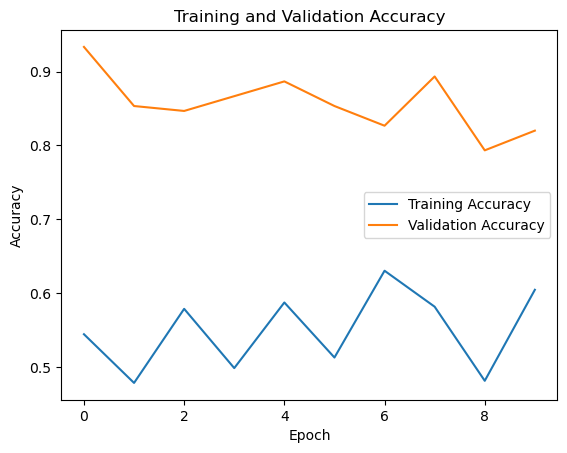

In [11]:
import matplotlib.pyplot as plt
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')

# Set labels and title
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot

plt.show()

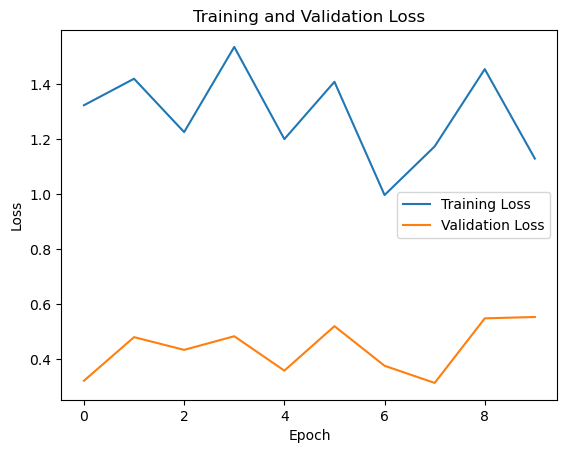

In [12]:
import matplotlib.pyplot as plt
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Set labels and title
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plot

plt.show()